# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**The problem**

that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has two steps. First, I will combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. Second, I will assess the accuracy and F1-score of a naive model that assumes all offers were successful. This provides me with a baseline for evaluating the performance of models that I construct. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight into its performance. I chose the F1-score metric because it is "a weighted average of the precision and recall metrics".


In [37]:
# IMPORTING LIBRARIES
import re
import math
import json
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

% matplotlib inline

# Import Data

In [38]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Access Portfolio Data


In [39]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [40]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [41]:
# view the shape of dateset
portfolio.shape

(10, 6)

In [42]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [43]:
portfolio.duration.unique()

array([ 7,  5,  4, 10,  3])

In [44]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

In [45]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [46]:
# count the number of offer by offer type
portfolio.groupby('offer_type').id.count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

# Clean Portfolio Data

In [47]:
#create dummy columns
portfolio=portfolio.join(portfolio['channels'].str.join('|').str.get_dummies().add_prefix('channel_'))

In [48]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [49]:
# quick check on missing value in dataset
portfolio.isnull().sum()

channels          0
difficulty        0
duration          0
id                0
offer_type        0
reward            0
channel_email     0
channel_mobile    0
channel_social    0
channel_web       0
dtype: int64

In [50]:
#change duration from days to hours..
portfolio.duration = portfolio.duration*24

In [15]:
# portfolio: rename id col name to offer_id.
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [51]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


# Access Profile Data


In [16]:
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [18]:
profile.shape

(17000, 5)

In [19]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [20]:
# No of unique users
profile.id.nunique()

17000

In [21]:
# getting the statitical summary of the 'age' column
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [22]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

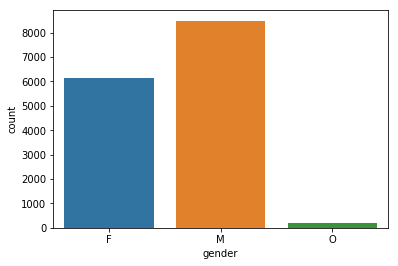

In [23]:
sns.countplot(profile['gender'])

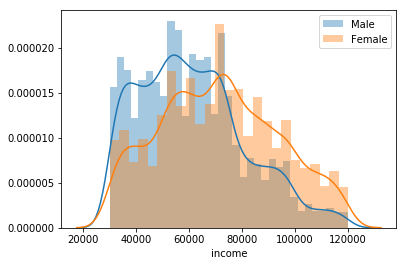

In [24]:
## Gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

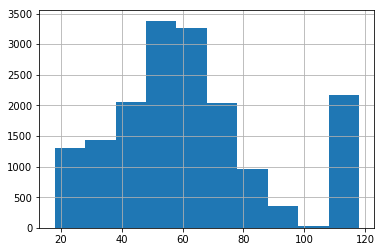

In [25]:
# age distribution
profile.age.hist();

We can clearly deduce here that 118 is an outlier as it doesn't follow the normal distribution



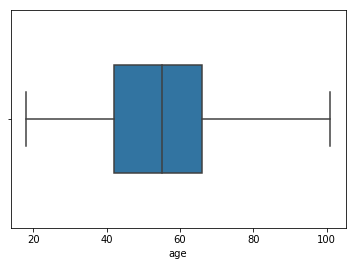

In [36]:
sns.boxplot(profile['age'], width=0.5);

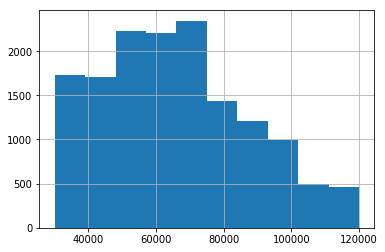

In [26]:
profile['income'].hist();

Customers income ranges from 30,000 and 120,000 with most of the customers’ incomes fall between 50,000 and 75,0000.

In [27]:
profile[['gender','age']].groupby(['gender'], as_index = False).mean().sort_values(by='age',ascending=False)

,gender,age
0,F,57.544950
2,O,54.400943
1,M,52.116690


 Mean age in female customers are older than customers with gender labeled as other then male customers

In [28]:
profile[['gender','income']].groupby(['gender'], as_index = False).mean().sort_values(by='income',ascending=False)

,gender,income
0,F,71306.412139
2,O,63287.735849
1,M,61194.601603


 Mean income in female customers are more than customers with gender labeled as other then male customers

# Clean Profile Data

In [29]:
# profile: change age value 118 to nan.
profile.age.replace(118, np.nan, inplace=True)
    
# Remove customers with N/A income data
profile = profile[profile['income'].notnull()]

# Change the name of the 'id' column to 'customer_id'
profile.rename(columns={'id': 'customer_id'}, inplace=True)
    
# profile: create readable date format for became_member_on column.
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")
    
# profile: drop rows with no gender, income, age data
profile.dropna(subset=['gender', 'income'], inplace = True)
profile.drop(profile[profile.age == 118].index, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site

In [30]:
# profile: add start_year column
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
# Convert gender values to numeric 0s and 1s
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
profile

,age,became_member_on,gender,customer_id,income,start_year,start_month
1,55.0,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75.0,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68.0,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65.0,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58.0,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11
13,61.0,2017-09-11,0,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017,9
14,26.0,2014-02-13,1,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014,2
15,62.0,2016-02-11,0,31dda685af34476cad5bc968bdb01c53,71000.0,2016,2
16,49.0,2014-11-13,1,62cf5e10845442329191fc246e7bcea3,52000.0,2014,11
18,57.0,2017-12-31,1,6445de3b47274c759400cd68131d91b4,42000.0,2017,12


In [33]:
# quick check on missing value in dataset
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
start_year          0
start_month         0
dtype: int64

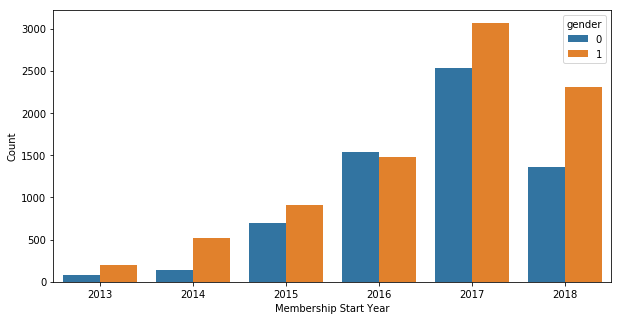

In [34]:
# groupby start_year and gender to plot a graph
membership_date = profile.groupby(['start_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['start_year', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='start_year', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

The results suggest that most customers joined the Starbucks rewards program in 2017 followed by 2018. Plots also depict that there are more male customers joining the program every year

# Transcript dataset


In [165]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [166]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [167]:
# quick check on missing value
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [168]:
#event distribution
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

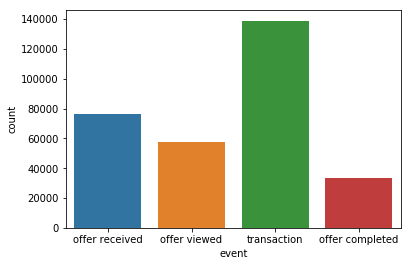

In [169]:
sns.countplot(transcript['event'])

There are 4 event type in transcript: customer received an offer, customer view an offer, customer perform a transaction, and customer complete an offer.


In [170]:
transcript['value'].value_counts().head()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
Name: value, dtype: int64

In [171]:
transcript['value'].value_counts().tail()

{'amount': 439.14}    1
{'amount': 42.75}     1
{'amount': 650.75}    1
{'amount': 943.4}     1
{'amount': 44.21}     1
Name: value, dtype: int64

# Clean Transcript Data


In [172]:
def clean_transcript(transcript):
    
    # transcript: rename person col name to customer_id.
    transcript.rename(columns={'person': 'customer_id'}, inplace=True)
   
    # transcript: drop transaction rows whose customer_id is not in profile:customer_id
    transcript = transcript[transcript.customer_id.isin(profile.customer_id)]
    
    
   #Create separate columns for amount, reward and offer_id from value column.

    
    transcript['offer_id'] = ''
    transcript['amount'] = 0
    transcript['reward'] = 0
    #Iterate over value column, check it and update offer_id, amount, reward columns
    for index, row in transcript.iterrows():
        for i in row['value']:
            if i == 'offer_id' or i == 'offer id':
                transcript.at[index, 'offer_id']= row['value'][i]
            if i == 'amount':
                transcript.at[index, 'amount']= row['value'][i]
            if i == 'reward':
                transcript.at[index, 'reward']= row['value'][i]
    # map offer type to offer id           
    offers_map = {
        'fafdcd668e3743c1bb461111dcafc2a4' : 'discount',
        '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',
        '2298d6c36e964ae4a3e7e9706d1fb8c2':'discount',
        '2906b810c7d4411798c6938adc9daaa5':'discount',
        'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',
        '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo',
        '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo',
        'f19421c1d4aa40978ebb69ca19b0e20d':'bogo',
        '3f207df678b143eea3cee63160fa8bed':'informational',
        '5a8bc65990b245e5a138643cd4eb9837':'informational',
        
        
        
    }
    
    #create offer_type column 
    transcript['offer_type'] = transcript['offer_id'].map(offers_map)
    # Drop value column
    transcript.drop('value', axis = 1, inplace = True)
    
    # Change time column from hours to days
    transcript['time'] = transcript['time']/24.
    
    return transcript

In [173]:
# update datafram
transcript = clean_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

In [174]:
transcript

,event,customer_id,time,offer_id,amount,reward,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo
2,offer received,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,0,0,discount
5,offer received,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,0,0,bogo
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,0,0,informational
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount
9,offer received,31dda685af34476cad5bc968bdb01c53,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount
12,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0.00,ae264e3637204a6fb9bb56bc8210ddfd,0,0,bogo
13,offer received,c27e0d6ab72c455a8bb66d980963de60,0.00,3f207df678b143eea3cee63160fa8bed,0,0,informational
14,offer received,d53717f5400c4e84affdaeda9dd926b3,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount
15,offer received,f806632c011441378d4646567f357a21,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount


In [175]:
transcript.drop_duplicates(inplace=True)

In [176]:
transcript.duplicated().sum()

0

In [177]:
# Calculate percentage of transaction and offer events
event_transaction = transcript['event'].value_counts()[0]
event_offers = transcript['event'].value_counts()[1:].sum()
event_total = transcript['event'].shape[0]

print('Percentage of transaction events are: {}%'.format(round((event_transaction/event_total)*100,2)))
print('Percentage of offers events are: {}%'.format(round((event_offers/event_total)*100,2)))

Percentage of transaction events are: 45.51%
Percentage of offers events are: 54.49%


In [178]:
# Print unique values in feature event
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [179]:
#Those purchased and have received an offer
transcript[transcript.event=='offer completed'].head(5)

,event,customer_id,time,offer_id,amount,reward,offer_type
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,2906b810c7d4411798c6938adc9daaa5,0,2,discount
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,2,discount
12679,offer completed,629fc02d56414d91bca360decdfa9288,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,bogo
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0.0,ae264e3637204a6fb9bb56bc8210ddfd,0,10,bogo
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10,bogo


In [180]:
#Those purchased without an offer
transcript[transcript.event=='transaction'].head(5)

,event,customer_id,time,offer_id,amount,reward,offer_type
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,,0,0,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,,34,0,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0.0,,13,0,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,,19,0,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,,18,0,NaN


In [181]:
# encode event and offer type columns
transcript = pd.get_dummies(transcript, columns=['event'], prefix = '', prefix_sep='')
transcript= pd.get_dummies(transcript, columns = ['offer_type'], prefix = '', prefix_sep='')

In [182]:
# sum all custumer's numeric data
transcript = transcript.groupby('customer_id').sum().reset_index()

In [183]:
transcript =  transcript.drop('transaction', axis = 1)

In [184]:
transcript

,customer_id,time,amount,reward,offer completed,offer received,offer viewed,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,392.25,125,9,3,5,4,3,5,4
1,0011e0d4e6b944f998e987f904e8c1e5,273.75,77,13,3,5,5,3,6,4
2,0020c2b971eb4e9188eac86d93036a77,265.75,193,14,3,5,3,4,5,2
3,0020ccbbb6d84e358d3414a3ff76cffd,359.25,148,13,3,4,4,6,3,2
4,003d66b6608740288d6cc97a6903f4f0,488.25,40,9,3,5,4,0,8,4
5,00426fe3ffde4c6b9cb9ad6d077a13ea,271.00,59,2,1,5,2,0,6,2
6,004b041fbfe44859945daa2c7f79ee64,247.00,135,7,2,3,2,3,3,1
7,004c5799adbf42868b9cff0396190900,469.50,342,24,5,5,4,8,6,0
8,005500a7188546ff8a767329a2f7c76a,195.75,19,5,1,5,3,8,1,0
9,0056df74b63b4298809f0b375a304cf4,257.00,141,13,3,4,3,3,5,2


In [185]:
df = pd.merge(  transcript, profile,  on = 'customer_id', how = 'right')

In [186]:
df

,customer_id,time,amount,reward,offer completed,offer received,offer viewed,bogo,discount,informational,age,became_member_on,gender,income,start_year,start_month
0,0009655768c64bdeb2e877511632db8f,392.25,125,9,3,5,4,3,5,4,33.0,2017-04-21,1,72000.0,2017,4
1,0011e0d4e6b944f998e987f904e8c1e5,273.75,77,13,3,5,5,3,6,4,40.0,2018-01-09,0,57000.0,2018,1
2,0020c2b971eb4e9188eac86d93036a77,265.75,193,14,3,5,3,4,5,2,59.0,2016-03-04,0,90000.0,2016,3
3,0020ccbbb6d84e358d3414a3ff76cffd,359.25,148,13,3,4,4,6,3,2,24.0,2016-11-11,0,60000.0,2016,11
4,003d66b6608740288d6cc97a6903f4f0,488.25,40,9,3,5,4,0,8,4,26.0,2017-06-21,0,73000.0,2017,6
5,00426fe3ffde4c6b9cb9ad6d077a13ea,271.00,59,2,1,5,2,0,6,2,19.0,2016-08-09,0,65000.0,2016,8
6,004b041fbfe44859945daa2c7f79ee64,247.00,135,7,2,3,2,3,3,1,55.0,2018-05-08,0,74000.0,2018,5
7,004c5799adbf42868b9cff0396190900,469.50,342,24,5,5,4,8,6,0,54.0,2016-03-31,1,99000.0,2016,3
8,005500a7188546ff8a767329a2f7c76a,195.75,19,5,1,5,3,8,1,0,56.0,2017-12-09,1,47000.0,2017,12
9,0056df74b63b4298809f0b375a304cf4,257.00,141,13,3,4,3,3,5,2,54.0,2016-08-21,1,91000.0,2016,8


# Average income of customers 

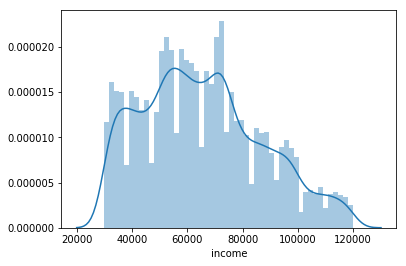

In [197]:
sns.distplot(df['income'], bins=50, hist_kws={'alpha': 0.4});

# Modeling data

In [187]:
model_data= df[['time', 'offer completed', 'amount', 'reward','age' , 'gender' , 'income']]

In [188]:
model_data

,time,offer completed,amount,reward,age,gender,income
0,392.25,3,125,9,33.0,1,72000.0
1,273.75,3,77,13,40.0,0,57000.0
2,265.75,3,193,14,59.0,0,90000.0
3,359.25,3,148,13,24.0,0,60000.0
4,488.25,3,40,9,26.0,0,73000.0
5,271.00,1,59,2,19.0,0,65000.0
6,247.00,2,135,7,55.0,0,74000.0
7,469.50,5,342,24,54.0,1,99000.0
8,195.75,1,19,5,56.0,1,47000.0
9,257.00,3,141,13,54.0,1,91000.0


In [189]:
model_data.isnull().sum()

time               0
offer completed    0
amount             0
reward             0
age                0
gender             0
income             0
dtype: int64

In [190]:
X = model_data[['time', 'amount', 'reward', 'age', 'gender', 'income']]
y = model_data['offer completed']

In [191]:
scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'reward', 'age', 'gender', 'income']

X[to_normalize] = scaler.fit_transform(X[to_normalize])
X.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,time,amount,reward,age,gender,income
0,0.438988,0.077833,0.18,0.180723,1.0,0.466667
1,0.296174,0.047945,0.26,0.265060,0.0,0.300000
2,0.286532,0.120174,0.28,0.493976,0.0,0.666667
3,0.399217,0.092154,0.26,0.072289,0.0,0.333333
4,0.554685,0.024907,0.18,0.096386,0.0,0.477778


In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [193]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)i

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [194]:
dt_pred = dt.predict(X_test)

In [195]:
print('DecisionTreeClassifier F1 Score {}'.format(dt.score(X_train, y_train)))
print('DecisionTreeClassifier Predition Accuracy {}'.format(accuracy_score(y_test, dt_pred)))

DecisionTreeClassifier F1 Score 1.0
DecisionTreeClassifier Predition Accuracy 0.6876180199622336


In [196]:
from sklearn.model_selection import GridSearchCV
#Initialize the classifier
clf = DecisionTreeClassifier()

# Create the parameters list to tune.

parameters =  {'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}



# Perform grid search on the classifier  using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))

Unoptimized model
------
Accuracy score on testing data: 0.6895

Optimized Model
------
Final accuracy score on the testing data: 0.7281


# Conclusion

The goal of this project is to predict how the customer will interact with the offers that Starbuck will present/send. Firstly I took the provided data that requires some cleaning activity, then I did the needed changes to analyze that data that required to be applied before starting the data exploring activity. Finally, I used one classification which is the decision tree classifier, and as a result of some improvements, I got 72% accuracy rate.
As a result of modeling the data, we found the females are more excited in the offer, and Starbuck should enhance their offers based on the provided result.
Moreover, Starbuck can use the model to enhance their offers periodically after each offer to know the real benefits to aim their offer to the correct audience